In [5]:
import torch
import sys
import numpy as np
from matplotlib import pyplot as plt

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from AttentionUnet import UNetWithAttention, inference_image, inference_dataset, img_kp_pred_and_gr, load_keypoints_from_csv, compute_pck_metrics

device = 'cuda' if torch.cuda.is_available() else 'cpu'

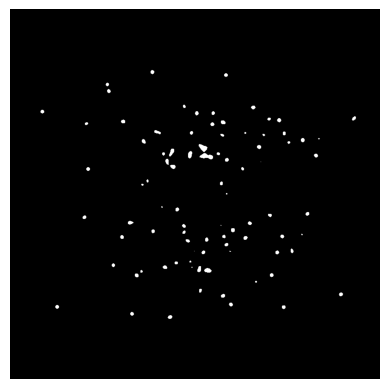

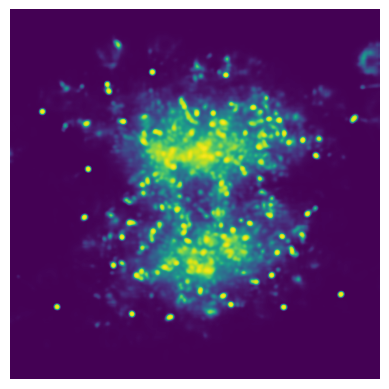

([0.7325581395348837], [0.40384615384615385], [0.5206611570247934])


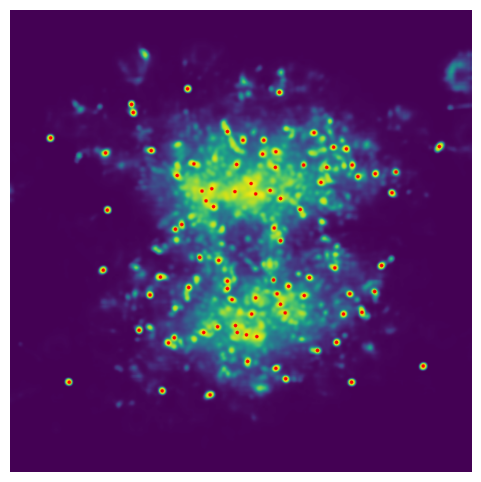

In [7]:
model_path = '/user/gr1/delphi/dghezzi/best_unet4.pth'
model = UNetWithAttention(in_channels=1, out_channels=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # modalità valutazione (disabilita dropout, batchnorm, ecc)

heatmap, keypoint_cov, _ = inference_image(beta=1, model=model, img_path='/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px/images/val/event_8.npy', device=device, threshold=0.95, show_mask=True)

kp_pred = [kp for kp,cov in keypoint_cov]
print(compute_pck_metrics(kp_pred, load_keypoints_from_csv('/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px/centers/val/event_8_centers.csv'), thresholds=[8]))

import cv2
# heatmap: array 2D float tra 0 e 1
heatmap_uint8 = (heatmap * 255).astype(np.uint8)  # da float 0-1 a uint8 0-255
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)  # aggiunge colore

# Disegna i keypoint con OpenCV
for kp in kp_pred:
    x, y = int(kp[0]), int(kp[1])
    cv2.circle(heatmap_color, (x, y), radius=3, color=(0,0,255), thickness=-1)  # rosso pieno

# OpenCV usa BGR, matplotlib usa RGB, quindi converti
heatmap_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# Mostra con Matplotlib
plt.figure(figsize=(6,6))
plt.imshow(heatmap_rgb)
plt.axis('off')
plt.show()




[INFO] Calcolo con binary_threshold=0.800 ...

[INFO] Calcolo con binary_threshold=0.805 ...

[INFO] Calcolo con binary_threshold=0.810 ...

[INFO] Calcolo con binary_threshold=0.815 ...

[INFO] Calcolo con binary_threshold=0.820 ...

[INFO] Calcolo con binary_threshold=0.825 ...

[INFO] Calcolo con binary_threshold=0.830 ...

[INFO] Calcolo con binary_threshold=0.835 ...

[INFO] Calcolo con binary_threshold=0.840 ...

[INFO] Calcolo con binary_threshold=0.845 ...

[INFO] Calcolo con binary_threshold=0.850 ...

[INFO] Calcolo con binary_threshold=0.855 ...

[INFO] Calcolo con binary_threshold=0.860 ...

[INFO] Calcolo con binary_threshold=0.865 ...

[INFO] Calcolo con binary_threshold=0.870 ...

[INFO] Calcolo con binary_threshold=0.875 ...

[INFO] Calcolo con binary_threshold=0.880 ...

[INFO] Calcolo con binary_threshold=0.885 ...

[INFO] Calcolo con binary_threshold=0.890 ...

[INFO] Calcolo con binary_threshold=0.895 ...

[INFO] Calcolo con binary_threshold=0.900 ...

[INFO] Calco

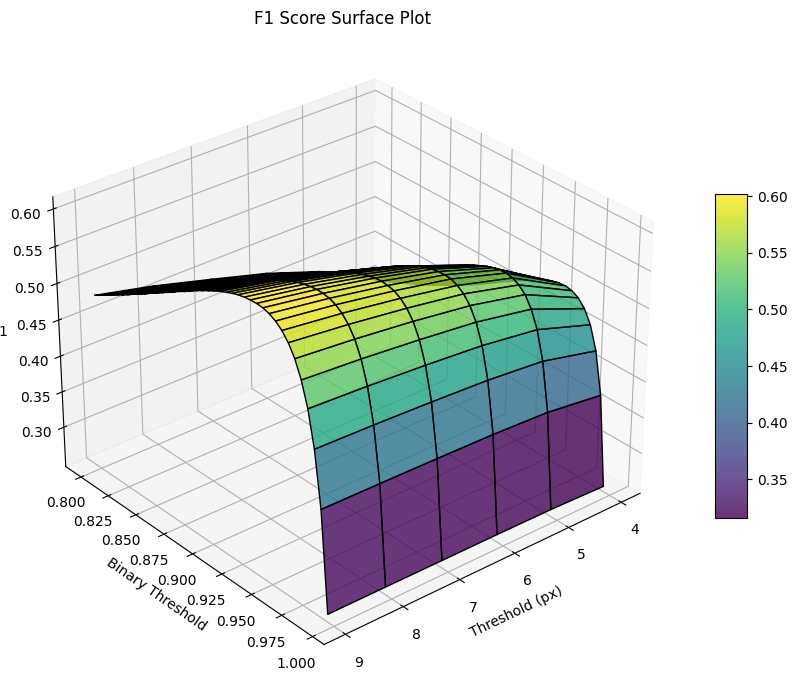

In [3]:
from AttentionUnet import inference_F1map_unet

datapath = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px'
output_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/output'
model_path = '/user/gr1/delphi/dghezzi/best_unet4.pth'


f1_matrix = inference_F1map_unet(
    dataset_path=datapath,
    model_path=model_path,
    img_size=800,
    pixel_thresholds=[4,5,6,7,8,9],
    binary_thresholds=np.arange(0.80, 1, 0.005),
    beta=1
)

In [11]:
# da f1 matrix estrapola valore max di binary threshold @8px
import pandas as pd

datapath = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px'
output_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/output'
model_path = '/user/gr1/delphi/dghezzi/best_unet4.pth'

f1_matrix = pd.read_csv(
    '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/beta=1/BCEL1dice/F1_matrix_unet.csv',
    header=None
).values

thresholds = np.loadtxt('/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/beta=1/BCEL1dice/F1_axis_pixel_thresholds.csv', delimiter=',')
binary = np.loadtxt('/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/beta=1/BCEL1dice/F1_axis_binary_thresholds.csv', delimiter=',')

idx = np.where(thresholds == 8)[0][0]
f1_at_threshold = f1_matrix[:, idx]
max_binary = binary[np.argmax(f1_at_threshold)]

print(f'best binary threshold @8px is {max_binary}')
print(f1_at_threshold[np.argmax(f1_at_threshold)])

best binary threshold @8px is 0.94
0.5954


In [12]:
datapath = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px'
output_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/output'
model_path = '/user/gr1/delphi/dghezzi/best_unet4.pth'

stats = inference_dataset(
    datapath=datapath,
    model_path=model_path,
    output_path=output_path,
    threshold=0.94,
    pixel_thresholds=[8],
    beta=1
)


print(stats)

{'precision': [0.7715317179092878], 'recall': [0.48575282047671636], 'f1': [0.595442822197372], 'std_f1': [0.03177469222796406], 'stdmean_f1': [0.0006354938445592811], 'inference_time_array': array([0.24368453, 0.2195816 , 0.21330166, ..., 0.23583817, 0.21017289,
       0.22744489]), 'inference_time': 0.2234830364227295, 'std_time': 0.00029114982308049963, 'mean_number_predictedKP': 102.3616, 'std_number_predictedKP': 0.15899842192927577}


il valore di F1 con beta=1 e beta=2 sono uguali per max binary confidence!!!


[INFO] Calcolo con binary_threshold=0.800 ...

[INFO] Calcolo con binary_threshold=0.805 ...

[INFO] Calcolo con binary_threshold=0.810 ...

[INFO] Calcolo con binary_threshold=0.815 ...

[INFO] Calcolo con binary_threshold=0.820 ...

[INFO] Calcolo con binary_threshold=0.825 ...

[INFO] Calcolo con binary_threshold=0.830 ...

[INFO] Calcolo con binary_threshold=0.835 ...

[INFO] Calcolo con binary_threshold=0.840 ...

[INFO] Calcolo con binary_threshold=0.845 ...

[INFO] Calcolo con binary_threshold=0.850 ...

[INFO] Calcolo con binary_threshold=0.855 ...

[INFO] Calcolo con binary_threshold=0.860 ...

[INFO] Calcolo con binary_threshold=0.865 ...

[INFO] Calcolo con binary_threshold=0.870 ...

[INFO] Calcolo con binary_threshold=0.875 ...

[INFO] Calcolo con binary_threshold=0.880 ...

[INFO] Calcolo con binary_threshold=0.885 ...

[INFO] Calcolo con binary_threshold=0.890 ...

[INFO] Calcolo con binary_threshold=0.895 ...

[INFO] Calcolo con binary_threshold=0.900 ...

[INFO] Calco

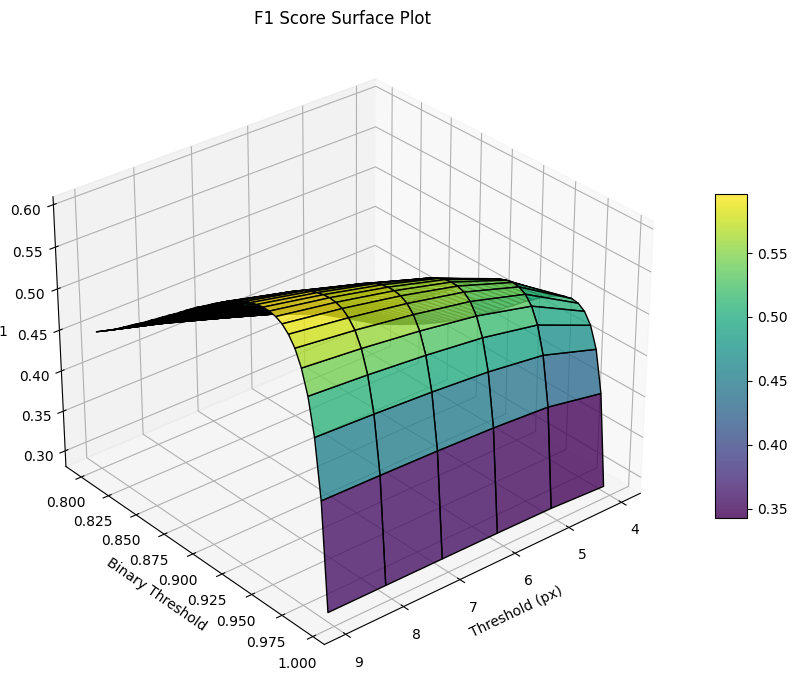

In [19]:
from AttentionUnet import inference_F1map_unet

datapath = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px'
output_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/output'
model_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/lossBCEL1/last.pth'


f1_matrix = inference_F1map_unet(
    dataset_path=datapath,
    model_path=model_path,
    img_size=800,
    pixel_thresholds=[4,5,6,7,8,9],
    binary_thresholds=np.arange(0.80, 1, 0.005),
    beta=1
)

In [20]:
# da f1 matrix estrapola valore max di binary threshold @8px
import pandas as pd

f1_matrix = pd.read_csv(
    '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/beta=1/F1_matrix_unet.csv',
    header=None
).values

thresholds = np.loadtxt('/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/beta=1/F1_axis_pixel_thresholds.csv', delimiter=',')
binary = np.loadtxt('/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/beta=1/F1_axis_binary_thresholds.csv', delimiter=',')

idx = np.where(thresholds == 8)[0][0]
f1_at_threshold = f1_matrix[:, idx]
max_binary = binary[np.argmax(f1_at_threshold)]

print(f'best binary threshold @8px is {max_binary}')
print(f1_at_threshold[np.argmax(f1_at_threshold)])

best binary threshold @8px is 0.95
0.5898


In [21]:
stats = inference_dataset(
    datapath=datapath,
    model_path=model_path,
    output_path=output_path,
    threshold=binary[np.argmax(f1_at_threshold)],
    pixel_thresholds=[8]
)

In [22]:
print(stats)

{'precision': [0.8834524376792245], 'recall': [0.40506493544672223], 'f1': [0.5546597637753593], 'std_f1': [0.03320779998947265], 'stdmean_f1': [0.0006641559997894531], 'inference_time_array': array([0.18944693, 0.17332625, 0.17540121, ..., 0.19172812, 0.15452647,
       0.16578221]), 'inference_time': 0.17339825086593627, 'std_time': 0.00023419273368007019, 'mean_number_predictedKP': 74.4892, 'std_number_predictedKP': 0.1258180962501023}


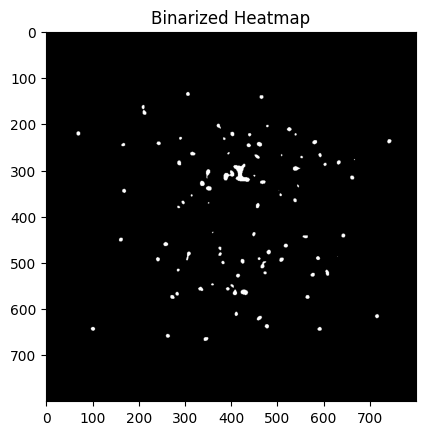

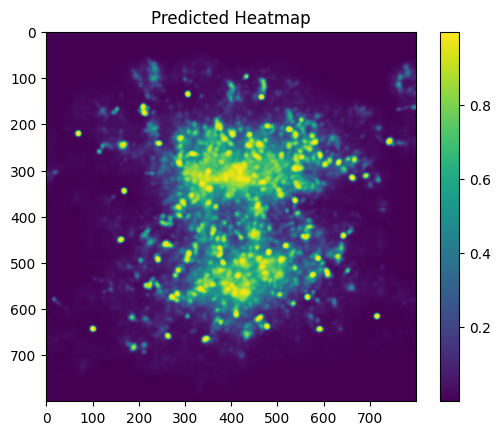

([0.7701149425287356], [0.42948717948717946], [0.551440329218107])


In [ ]:
import 

model_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/lossBCEL1/last.pth'
model = UNetWithAttention(in_channels=1, out_channels=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # modalità valutazione (disabilita dropout, batchnorm, ecc)

heatmap, keypoint_cov, _ = inference_image(beta=1, model=model, img_path='/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px/images/val/event_8.npy', device=device, threshold=0.95, show_mask=True)

kp_pred = [kp for kp,cov in keypoint_cov]
print(compute_pck_metrics(kp_pred, load_keypoints_from_csv('/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px/centers/val/event_8_centers.csv'), thresholds=[8]))

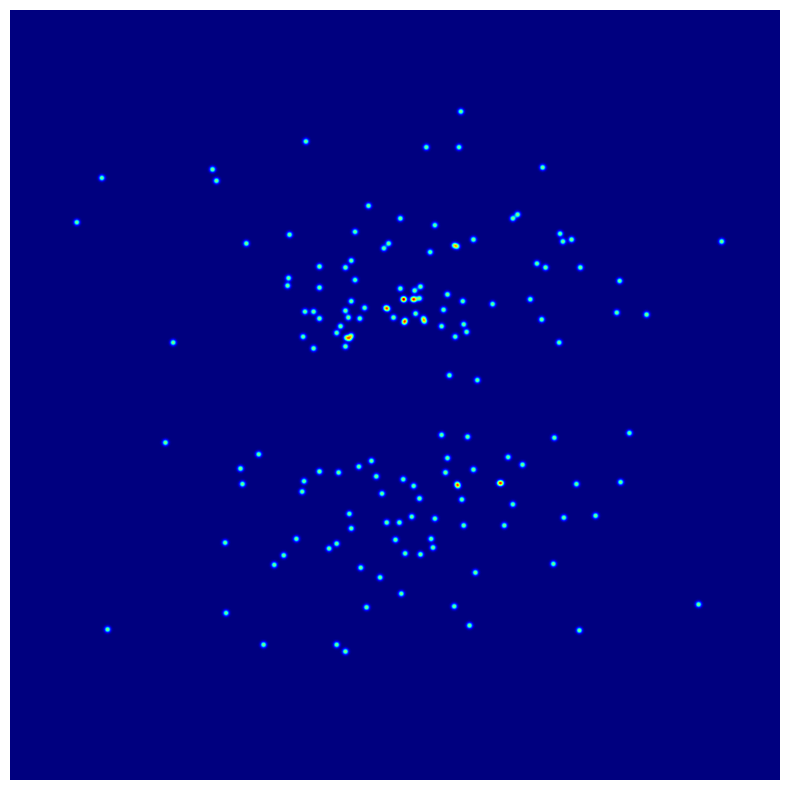

In [19]:
import numpy as np
import matplotlib.pyplot as plt

directory = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px/labels/val/event_8.npy'
img = np.load(directory)  

plt.figure(figsize=(10,10))
im = plt.imshow(img, cmap='jet')
plt.axis('off')
plt.show()


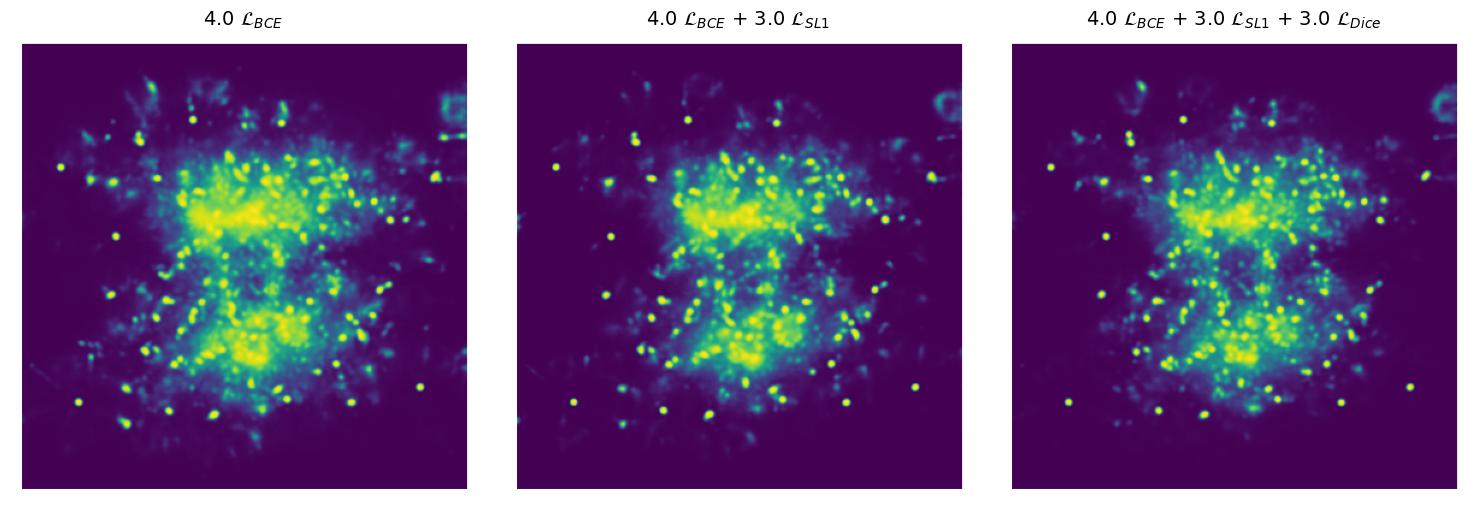

In [8]:
import matplotlib.pyplot as plt
import cv2

# Percorsi immagini
img_paths = [
    '/user/gr1/delphi/dghezzi/UNet/BCE.png',
    '/user/gr1/delphi/dghezzi/UNet/BCE03L1.png',
    '/user/gr1/delphi/dghezzi/UNet/BCEL1Dice.png'
]

titles = [r'4.0 $\mathcal{L}_{BCE}$', 
          r'4.0 $\mathcal{L}_{BCE}$ + 3.0 $\mathcal{L}_{SL1}$', 
          r'4.0 $\mathcal{L}_{BCE}$ + 3.0 $\mathcal{L}_{SL1}$ + 3.0 $\mathcal{L}_{Dice}$']

# Crea figure con 1 riga e 3 colonne
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax, path, title in zip(axs, img_paths, titles):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    ax.imshow(img)
    ax.set_title(title, fontsize=14)
    ax.axis('off')  # disabilita assi

plt.tight_layout()
plt.show()
